# Successors Experimentation
Attempting to figure out how to use GerryChain classes/methods to find successors of a partition. 

In [1]:
# Slow imports
import descartes
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd


In [2]:
# Other imports
import csv
import math
import os
import random
import timeit

from gerrychain import Graph, Partition
from gerrychain.updaters import cut_edges, Tally

import compatibility

In [3]:
# Load data
HOME_DIR = os.path.expanduser("~")
DATA_DIR = '{0}/{1}'.format(HOME_DIR, 'Documents/Data') 
tracts_fpath = 'zip://{0}/{1}'.format(DATA_DIR, 'Census/Wisconsin/tl_2013_55_tract.zip')
gdf = gpd.read_file(tracts_fpath)
gdf = gdf.set_index('GEOID')

pop_fpath = '{0}/Census/Wisconsin/2010_CensusTractPopulations/DEC_10_SF1_P1_with_ann_modified.csv'.format(DATA_DIR)

with open(pop_fpath, 'r') as pop_file:
    pop_reader = csv.reader(pop_file)
    pop_raw = list(pop_reader)

pop_headers = pop_raw.pop(0)
pop_df = pd.DataFrame(pop_raw, columns=pop_headers).astype({"population": int})
pop_df = pop_df.drop(columns=['GEOIDLONG', 'DISPLAYNAME'])
pop_df = pop_df.set_index('GEOID')
gdf = gdf.join(pop_df)

In [4]:
# Test removal of zero-population units
gdf = gdf.loc[gdf["population"]!=0]

In [5]:
map_a_filepath = '{0}/ICOR/Wisconsin/wi-gerrymander-dem.csv'.format(DATA_DIR)
map_b_filepath = '{0}/ICOR/Wisconsin/wi-gerrymander-rep.csv'.format(DATA_DIR)

map_gdf = [None, None]

for i, map_fpath in enumerate([map_a_filepath, map_b_filepath]):
    with open(map_fpath) as map_file:
        map_reader = csv.reader(map_file)
        map_raw = list(map_reader)

    map_headers = map_raw.pop(0)
    map_df = pd.DataFrame(map_raw, columns=map_headers)
    map_df = map_df.set_index('GEOID')

    map_gdf[i] = gdf.join(map_df)
    map_gdf[i]['district'] = map_gdf[i]['district'].fillna(value=-1).astype(int)

In [6]:
# Create Partition objects from 
# map_gdf[0] (dem gerrymander) and 
# map_gdf[1] (rep gerrymander)
# (Takes a long time)
graph_dem = Graph.from_geodataframe(map_gdf[0], reproject=True)
graph_dem.add_data(map_gdf[0])
graph_rep = Graph.from_geodataframe(map_gdf[1], reproject=True)
graph_rep.add_data(map_gdf[1])
init_partition = Partition(
    graph=graph_dem,
    assignment='district', 
    updaters={'cut_edges': cut_edges, 'population': Tally("population")})
final_partition = Partition(
    graph=graph_rep, 
    assignment='district', 
    updaters={'cut_edges': cut_edges, 'population': Tally("population")})

Republican Map:
District 1 population: 737728
District 2 population: 737797
District 3 population: 712864
District 4 population: 702091
District 5 population: 711837
District 6 population: 677011
District 7 population: 680545
District 8 population: 727113

Democratic Map:
District 1 population: 681581
District 2 population: 691382
District 3 population: 737619
District 4 population: 706056
District 5 population: 735011
District 6 population: 678739
District 7 population: 736705
District 8 population: 719893



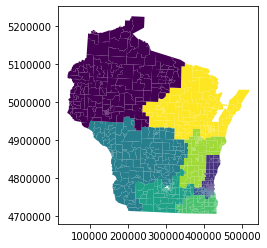

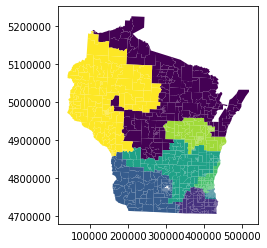

In [7]:
# Get rough sketch of both maps
for a in [0, 1]:
    print('Republican Map:' if a == 0 else 'Democratic Map:')
    for i in set(map_gdf[a]['district']):
        pop_i = map_gdf[a]['population'][map_gdf[a]['district'] == i].sum()
        print('District', i, 'population:', pop_i)
    print()
    if a == 0:
        init_partition.plot();
    else:
        final_partition.plot();

In [8]:
cut_edge = random.choice(list(init_partition.cut_edges))
print(cut_edge)

('55133203500', '55133203703')


In [10]:
# Generate list of feasible flips (one-swaps) to get successors.
# Based on propose_random_flip(): https://github.com/mggg/GerryChain/blob/master/gerrychain/proposals/proposals.py
partition = init_partition;
flips = []
for edge in partition['cut_edges']:
    for index in [0, 1]:
        flipped_node, other_node = edge[index], edge[1 - index]
        flips.append({flipped_node: partition.assignment[other_node]})        

In [12]:
all_units = set()
for part in partition.parts:
    if part > 0:
        all_units = all_units.union(partition.parts[part])

In [14]:
# compat_sorted = compat_ser.sort_values(ascending=False)
# print(compat_ser[0])
# print(compat_sorted[139])
# # compat_sorted.head(10)
# top_ten_compat = [139, 804, 796, 17, 270, 232, 26, 224, 306, 705]
# for i_plus_one in top_ten_compat:
#     i = i_plus_one - 1
#     unit = list(flips[i].keys())[0]
# #     print(flips[i])
# #     print(compat[i + 1])
# #     print(compat_manager.tally_property(set([unit])))
# np.unique(compat)

In [16]:
units_subset = init_partition.parts[3]
units_subset_ser = pd.Series(np.array(list(units_subset)), name='GEOID')
units_subset_ser
gdf_units = gdf.reset_index()
gdf_units['GEOID'] = gdf_units['GEOID']
gdf_units['GEOID']
# units_subset_ser
total_pop = gdf_units.merge(units_subset_ser, on='GEOID')['population'].sum()

In [17]:
total_pop

712864

In [18]:
init_partition

<Partition [8 parts]>

In [19]:
len(init_partition.parts)

8

In [20]:
gdf_reset = gdf.reset_index()
all_units = set(gdf_reset['GEOID'])

In [21]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'population'],
      dtype='object')

In [26]:
map_gdf[0].columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'population', 'district'],
      dtype='object')

In [34]:
df = pop_df.reset_index()

In [38]:
all_units = set(df['GEOID'])

In [43]:
init_partition.graph.nodes['55009002002']

{'boundary_node': False,
 'area': 3600128.9366311287,
 'STATEFP': '55',
 'COUNTYFP': '009',
 'TRACTCE': '002002',
 'NAME': '20.02',
 'NAMELSAD': 'Census Tract 20.02',
 'MTFCC': 'G5020',
 'FUNCSTAT': 'S',
 'ALAND': 3602498,
 'AWATER': 0,
 'INTPTLAT': '+44.4804525',
 'INTPTLON': '-087.9563805',
 'geometry': <shapely.geometry.polygon.Polygon at 0x234f0ca6448>,
 'population': 5157,
 'district': 8}